---
title: "Product Demand Forecast (hts)"
author: "Fang Zhou, Data Scientist, Microsoft"
output: 
    rmarkdown::html_vignette:
        toc: true

vignette: >
  %\VignetteIndexEntry{Vignette Title}
  %\VignetteEngine{knitr::rmarkdown}
  %\VignetteEncoding{UTF-8}
---

In [1]:

knitr::opts_chunk$set(fig.width = 6,
                      fig.height = 4,
                      fig.align ='center',
                      dev = "png")


# Introduction

In this documentation, we are trying to build a quartly by category demand forecast model on product booking quantity data using the package 'hts'. We implement the advanced analytics process with R in the principle of step-by-step. 

## Product booking quantity data

In [2]:
## Load the required packages into the R session.

library(dplyr)        # Missing value treatment with Filter.
library(zoo)          # Missing value treatment with locf method.
library(forecast)     # Time Series forecasting.
library(hts)          # Hierarchical time series forecasting.
library(fpp)          # Time Series cross validation.
library(foreach)      # Run for loop in parallel.


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Warning message in as.POSIXlt.POSIXct(Sys.time()):
"unable to identify current timezone 'C':
please set environment variable 'TZ'"Loading required package: SparseM

Attaching package: 'SparseM'

The following object is masked from 'package:base':

    backsolve

Loading required package: Matrix
Loading required package: matrixcalc
Loading required package: fma
Loading required package: expsmooth
Loading required package: lmtest
Loading required package: tseries


Let's load the data and take a brief glimpse of it.

In [3]:
## Set directory

setwd("C:/Demo/ProductDemandForecast")

wd <- getwd()

In [4]:
## Read data

dspath <- file.path(wd, "Data", "productQuantity.csv")

data <- read.table(dspath, header=TRUE, sep=",")

dim(data) # 56 11

str(data)

head(data)

[1] 56 10

'data.frame':	56 obs. of  10 variables:
 $ Year     : int  1998 1998 1998 1998 1999 1999 1999 1999 2000 2000 ...
 $ Quarter  : Factor w/ 4 levels "Q1","Q2","Q3",..: 1 2 3 4 1 2 3 4 1 2 ...
 $ Product.1: int  7320 6117 6282 6368 6602 5651 5710 6509 6589 5392 ...
 $ Product.2: int  21782 16881 13495 15963 22718 14775 14634 15669 20474 14522 ...
 $ Product.3: int  4865 4100 4418 5157 5550 3902 3970 3825 5706 4228 ...
 $ Product.4: int  14054 8237 6731 7675 13581 7883 6516 6834 12561 7801 ...
 $ Product.5: int  9055 5616 8298 6674 9168 7351 8322 7017 8706 7045 ...
 $ Product.6: int  8016 8461 13175 9092 10224 9672 14376 10620 9668 8885 ...
 $ Product.7: int  9178 6362 7965 6864 8908 7690 7998 7068 10484 7377 ...
 $ Product.8: int  10232 9540 12385 13098 10140 9948 10653 10781 11462 9217 ...


Year,Quarter,Product.1,Product.2,Product.3,Product.4,Product.5,Product.6,Product.7,Product.8
1998,Q1,7320,21782,4865,14054,9055,8016,9178,10232
1998,Q2,6117,16881,4100,8237,5616,8461,6362,9540
1998,Q3,6282,13495,4418,6731,8298,13175,7965,12385
1998,Q4,6368,15963,5157,7675,6674,9092,6864,13098
1999,Q1,6602,22718,5550,13581,9168,10224,8908,10140
1999,Q2,5651,14775,3902,7883,7351,9672,7690,9948


## Handling missing value

To clean the data, we remove some of columns with too many NAs (>10%) and replace other missing values with last-observation-carried-forward method.

In [5]:
## Clean missing value

# Remove columns with only NA

data <- Filter(function(x)!all(is.na(x)), data)
dim(data) # 56 10

# Remove columns with too many NAs 

data <- Filter(function(x)!(sum(is.na(x))/length(x)) > 0.1, data)
dim(data) # 56 10

# Remove rows with only missing values

missingRows <- apply(data, 1, function(x) all(is.na(x)))
data <- data[!missingRows, ]
dim(data)

# Replace NA values with last-observation-carried-forward method

data[,3:10] <- lapply(data[,3:10], function(x) { 
  x <- na.locf(x)
  x
})

head(data)

[1] 56 10

[1] 56 10

[1] 56 10

Year,Quarter,Product.1,Product.2,Product.3,Product.4,Product.5,Product.6,Product.7,Product.8
1998,Q1,7320,21782,4865,14054,9055,8016,9178,10232
1998,Q2,6117,16881,4100,8237,5616,8461,6362,9540
1998,Q3,6282,13495,4418,6731,8298,13175,7965,12385
1998,Q4,6368,15963,5157,7675,6674,9092,6864,13098
1999,Q1,6602,22718,5550,13581,9168,10224,8908,10140
1999,Q2,5651,14775,3902,7883,7351,9672,7690,9948


## Model building

We aim to build a time series model to fit the whole product booking quantity data. 

### Hierachical time series model

Hierarchical time series forecasting methods can be implemented in the hts package (Hyndman et al. 2014) for R (R Core Team 2013).

We can use hts function to create a hierarchical time series. The required inputs are the bottom-level time series, and information about the hierarchical structure. Knowing from the product category dataset, we can try this hierarchical structure: the series for product 1 and 2 belong to category A, series for product 3-8 belong to the category B.

Let's have a look at this 3-level hierarchical time series.

In [6]:
## Hierarchical time series modeling 

# Construct time series matrix

bts <- ts(data[, 3:10], frequency=4, start=c(1998, 1))

head(bts)

Product.1,Product.2,Product.3,Product.4,Product.5,Product.6,Product.7,Product.8
7320,21782,4865,14054,9055,8016,9178,10232
6117,16881,4100,8237,5616,8461,6362,9540
6282,13495,4418,6731,8298,13175,7965,12385
6368,15963,5157,7675,6674,9092,6864,13098
6602,22718,5550,13581,9168,10224,8908,10140
5651,14775,3902,7883,7351,9672,7690,9948


In [7]:
# Create 3-level hierarchical time series

demandgts <- hts(bts, nodes=list(2, c(2, 6)))

# Rename the nodes of the hierarchy

demandgts$labels$`Level 1` <- c("Category.A", "Category.B")
demandgts$labels$`Level 2` <- c("Product.1", "Product.2", "Product.3", "Product.4", 
                                "Product.5", "Product.6", "Product.7", "Product.8")
names(demandgts$labels) <- c("Total", "Category", "Product")

head(demandgts)
print(demandgts)

Since argument characters are not specified, the default labelling system is used.


Product.1,Product.2,Product.3,Product.4,Product.5,Product.6,Product.7,Product.8
7320,21782,4865,14054,9055,8016,9178,10232
6117,16881,4100,8237,5616,8461,6362,9540
6282,13495,4418,6731,8298,13175,7965,12385
6368,15963,5157,7675,6674,9092,6864,13098
6602,22718,5550,13581,9168,10224,8908,10140
5651,14775,3902,7883,7351,9672,7690,9948
5710,14634,3970,6516,8322,14376,7998,10653
6509,15669,3825,6834,7017,10620,7068,10781
6589,20474,5706,12561,8706,9668,10484,11462
5392,14522,4228,7801,7045,8885,7377,9217


Hierarchical Time Series 
3 Levels 
Number of nodes at each level: 1 2 8 
Total number of series: 11 
Number of observations per series: 56 
Top level series: 
      Qtr1  Qtr2  Qtr3  Qtr4
1998 84502 65314 72749 70891
1999 86891 66872 72179 68323
2000 85650 64467 70408 72859
2001 80389 67973 69836 71446
2002 83932 63526 75548 75651
2003 83863 67191 71395 71662
2004 85838 66979 73837 70224
2005 85994 59635 66840 63390
2006 82646 67520 65944 69550
2007 86241 67397 69512 69204
2008 87012 59762 66413 64678
2009 74378 57936 65403 64519
2010 74635 59704 67534 63521
2011 72274 62906 70499 64894


In [8]:
# Aggregate the hierarchy time series

alldemand <- aggts(demandgts) 

head(alldemand)

Total,Category.A,Category.B,Product.1,Product.2,Product.3,Product.4,Product.5,Product.6,Product.7,Product.8
84502,29102,55400,7320,21782,4865,14054,9055,8016,9178,10232
65314,22998,42316,6117,16881,4100,8237,5616,8461,6362,9540
72749,19777,52972,6282,13495,4418,6731,8298,13175,7965,12385
70891,22331,48560,6368,15963,5157,7675,6674,9092,6864,13098
86891,29320,57571,6602,22718,5550,13581,9168,10224,8908,10140
66872,20426,46446,5651,14775,3902,7883,7351,9672,7690,9948


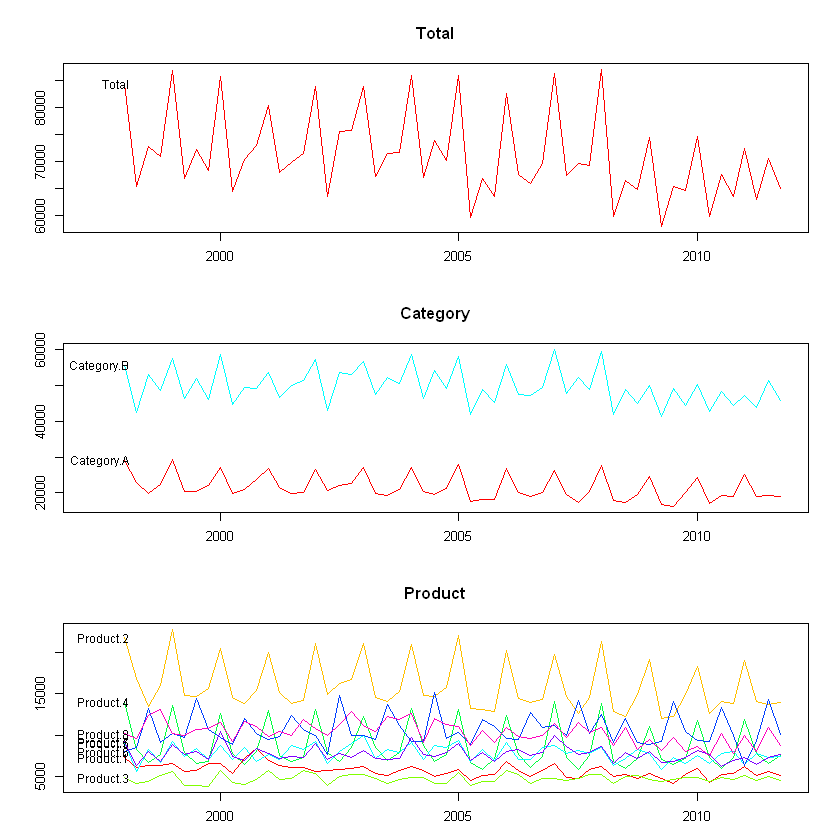

In [9]:
plot(demandgts, levels=c(0, 1, 2))

In [10]:
# Set up the training sample and testing sample

traingts <- window(demandgts, start=c(1998, 1), end=c(2009, 4))
testgts <- window(demandgts, start=c(2010, 1), end=c(2011, 4))

demandfcast <- forecast(object  = traingts, 
                        h       = 8, 
                        method  = "bu", 
                        fmethod = "arima",
                        keep.fitted = TRUE)

In [11]:
# Explore and visualize the forecasted hts

aggts(demandfcast)

Total,Category.A,Category.B,Product.1,Product.2,Product.3,Product.4,Product.5,Product.6,Product.7,Product.8
80910.32,25503.27,55407.04,5664.790,19838.48,4517.327,12756.530,8421.304,10418.541,9269.589,10023.754
60955.16,17453.11,43502.04,4556.185,12896.93,4580.720,7140.095,6485.093,9190.637,7737.238,8368.259
65529.24,16506.67,49022.56,4515.956,11990.72,4599.585,6089.073,7538.714,13150.783,7595.421,10048.987
65158.95,19359.68,45799.27,5017.735,14341.94,4764.995,7330.315,7478.676,10180.782,7597.098,8447.406
79841.63,25218.80,54622.83,5390.090,19828.71,4715.358,13041.323,8421.304,10051.862,8528.523,9864.458
59045.18,16654.93,42390.25,4417.989,12236.94,4715.358,6991.294,6485.093,9186.572,6802.969,8208.963
65235.18,16124.68,49110.50,4377.760,11746.92,4715.358,6046.043,7538.714,13381.272,7539.418,9889.692
64429.14,19211.76,45217.38,4879.539,14332.22,4715.358,7237.603,7478.676,10250.235,7247.400,8288.111


In [12]:
summary(demandfcast)

Hierarchical Time Series 
3 Levels 
Number of nodes at each level: 1 2 8 
Total number of series: 11 
Number of observations in each historical series: 48 
Number of forecasts per series: 8 
Top level series of forecasts: 
         Qtr1     Qtr2     Qtr3     Qtr4
2010 80910.32 60955.16 65529.24 65158.95
2011 79841.63 59045.18 65235.18 64429.14

Method: Bottom-up forecasts 
Forecast method: Arima 
In-sample error measures at the bottom level: 
       Product.1   Product.2   Product.3    Product.4   Product.5   Product.6
ME     1.8928374  -4.8896114  -1.2204182 -142.3460472 -14.0070931 228.3550637
RMSE 499.0780725 964.9571426 478.7228408  628.7161059 698.1542998 900.4151901
MAE  382.1519945 729.0429985 397.0558637  441.4047924 512.9018563 683.3038439
MAPE   6.5989311   4.7198640   8.5556556    5.2848997   6.7025632   6.1783808
MPE   -0.6422800  -0.3170459  -1.0771666   -1.9827212  -0.6736957   1.7844811
MASE   0.6440435   0.7252355   0.8330373    0.8035503   0.7797554   0.5915236
       

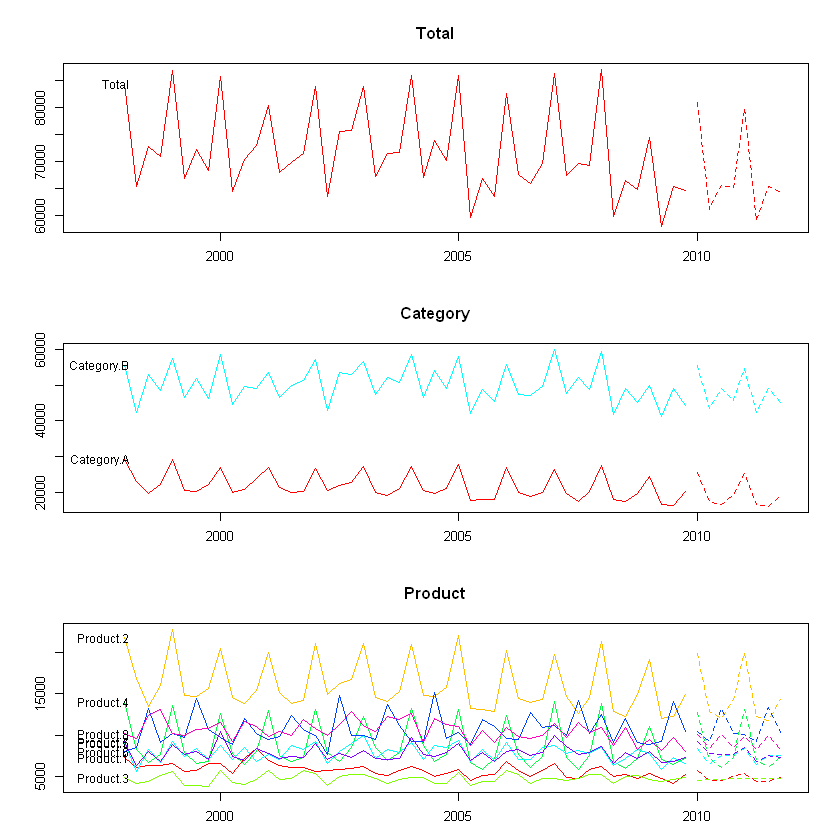

In [13]:
plot(demandfcast)

In [14]:
# Calculate perforemance metrics

accuracy.gts(demandfcast, testgts, levels=c(0, 1, 2))

,Total,Category.A,Category.B,Product.1,Product.2,Product.3,Product.4,Product.5,Product.6,Product.7,Product.8
ME,-642.2230633,769.636570,-1411.8596334,500.869555,268.767016,62.9927473,-57.9094758,-154.696664,-486.0854327,-601.7071073,-174.453701
RMSE,4297.4666959,1762.617949,3417.5795191,654.667459,1333.511536,265.5443482,637.9615525,923.545538,1410.7055499,824.2037457,733.337312
MAE,3540.7892002,1301.541868,2479.5780546,569.165681,1147.337404,248.6004751,512.4007731,663.302664,811.2695039,699.1071823,583.391671
MAPE,5.1052214,6.663495,5.2033361,10.476458,7.760610,5.1928806,5.6760678,9.321062,10.5272499,9.8886736,6.695530
MPE,-0.7830154,4.126951,-2.9651999,8.881871,2.442825,1.0706089,0.5462723,-2.757447,-8.0096851,-8.6133027,-2.666663
MASE,1.0928975,1.050883,0.9203532,0.959219,1.141345,0.5215726,0.9327941,1.008407,0.7023011,0.9238839,0.603485


### Cross-validation for hierarchical time series

Next, we use cross validation to compare performance of different forecast methods for hierarchical time series model.

In [15]:
## Time series cross validation

# Define function that runs hierarchical forecast on training data set
# and returns forecast on test data set

forecast_hts <- function (traindata, testdata, htsmethod, tsmethod) {
  
  # Forecasting horizon
  
  horiz =  dim(aggts(testdata))[1]

  # Run hierarchical forecast
  
  hts_fcast <- forecast(object  = traindata, 
                        h       = horiz,
                        method  = htsmethod,
                        fmethod = tsmethod,
                        keep.fitted = TRUE)
  
  # Return forecasted ts
  
  hts_fcast
  
  # Return evaluation metrics at the top level
  #fcast_acc <- accuracy.gts(hts_fcast, test = testdata, levels = 0)
}

In [ ]:
# Set parameters for cross validation

k <- 48 
n <- dim(demandgts$bts)[1]
st <- tsp(demandgts$bts)[1]+(k-2)/4

# Define parameter space for hts

hts_method <- c("bu", "comb", "tdgsa")
ts_method <- c("arima", "ets", "rw")

param_space <- expand.grid(hts_method, 
                           ts_method, 
                           stringsAsFactors = FALSE)

colnames(param_space) <- c("hts_method", "ts_method")

# Define empty matric matrix

mape11 <- mape12 <- mape13 <- mape21 <- mape22 <- mape23 <- mape31 <- mape32 <- mape33 <- matrix(NA,n-k,4)

# Conduct time series cross validation for hts forecasting in parallel

rxSetComputeContext("localpar")

tscv_time <- system.time({
  
foreach(i=1:(n-k)) %dopar%
{
  datashort <- window(demandgts, end=st + i/4)
  datanext <- window(demandgts, start=st + (i+1)/4, end=st + (i+4)/4)
  
  # Run many distributed jobs
    
  rxResult <- rxExec(FUN=forecast_hts,  
                     traindata=datashort, 
                     testdata=datanext, 
                     htsmethod=rxElemArg(param_space$hts_method),  
                     tsmethod=rxElemArg(param_space$ts_method),
                     consoleOutput=TRUE,
                     packagesToLoad=c('hts'))
  
  horiz <- dim(datanext$bts)[1]
  
  mape11[i, 1:horiz] <- accuracy(aggts(rxResult[[1]]), aggts(datanext))[1, "MAPE"]
  mape12[i, 1:horiz] <- accuracy(aggts(rxResult[[2]]), aggts(datanext))[1, "MAPE"]
  mape13[i, 1:horiz] <- accuracy(aggts(rxResult[[3]]), aggts(datanext))[1, "MAPE"]
  mape21[i, 1:horiz] <- accuracy(aggts(rxResult[[4]]), aggts(datanext))[1, "MAPE"]
  mape22[i, 1:horiz] <- accuracy(aggts(rxResult[[5]]), aggts(datanext))[1, "MAPE"]
  mape23[i, 1:horiz] <- accuracy(aggts(rxResult[[6]]), aggts(datanext))[1, "MAPE"]
  mape31[i, 1:horiz] <- accuracy(aggts(rxResult[[7]]), aggts(datanext))[1, "MAPE"]
  mape32[i, 1:horiz] <- accuracy(aggts(rxResult[[8]]), aggts(datanext))[1, "MAPE"]
  mape33[i, 1:horiz] <- accuracy(aggts(rxResult[[9]]), aggts(datanext))[1, "MAPE"]
}
  
})

Warning message:
"executing %dopar% sequentially: no parallel backend registered"Warning message in window.default(x, ...):
"'end' value not changed"Warning message in window.default(x, ...):
"'end' value not changed"

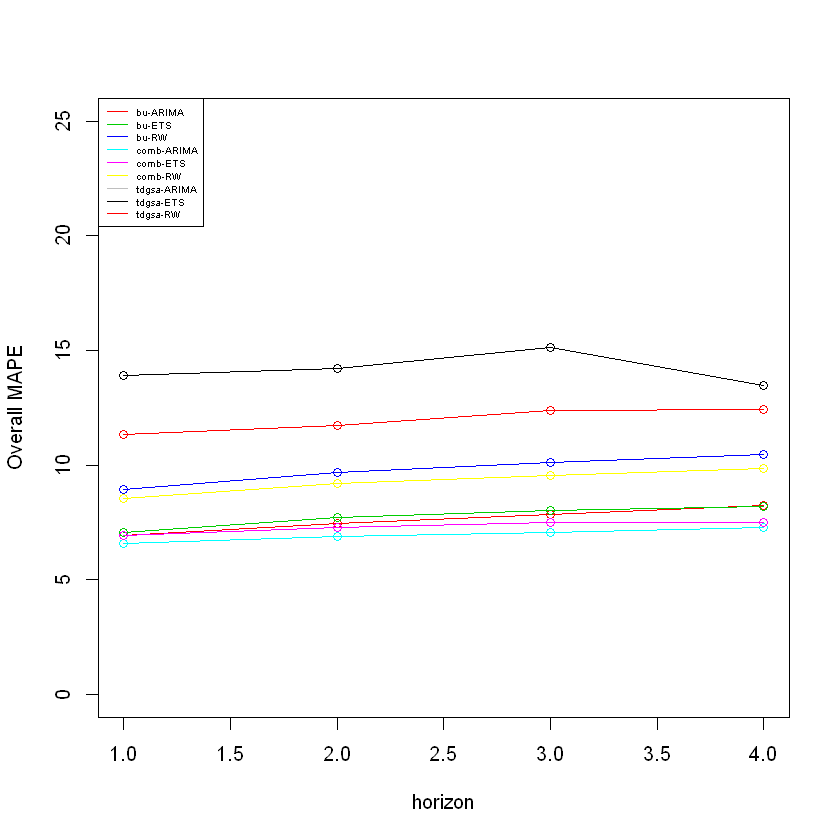

In [23]:
# Visualize overall mape vs horiz

plot(1:4, colMeans(mape11,na.rm=TRUE), type="o", col=2, 
     xlab="horizon", ylab="Overall MAPE", ylim=c(0, 25))
lines(1:4, colMeans(mape12,na.rm=TRUE), type="o",col=3)
lines(1:4, colMeans(mape13,na.rm=TRUE), type="o",col=4)
lines(1:4, colMeans(mape21,na.rm=TRUE), type="o",col=5)
lines(1:4, colMeans(mape22,na.rm=TRUE), type="o",col=6)
lines(1:4, colMeans(mape23,na.rm=TRUE), type="o",col=7)
lines(1:4, colMeans(mape31,na.rm=TRUE), type="o",col=8)
lines(1:4, colMeans(mape32,na.rm=TRUE), type="o",col=9)
lines(1:4, colMeans(mape33,na.rm=TRUE), type="o",col=10)
legend("topleft", 
       legend=c("bu-ARIMA", "bu-ETS", "bu-RW",
                "comb-ARIMA", "comb-ETS", "comb-RW",
                "tdgsa-ARIMA", "tdgsa-ETS", "tdgsa-RW"), 
       col=2:10, lty=1, cex=0.5)

In [ ]:
# Show the run time of time series cross validation

print(tscv_time)

In [ ]:
# Forecast the product demand of 2012 using the optimal parameters

opt_fcast <- forecast(object  = demandgts, 
                      h       = 4,
                      method  = "comb",
                      fmethod = "arima",
                      keep.fitted = TRUE)

In [ ]:
# Explore and visualize the forecasted hts

aggts(opt_fcast)

In [ ]:
summary(opt_fcast)

In [ ]:
plot(opt_fcast)